drifver path /home/max/.wdm/drivers/chromedriver/linux64/120.0.6099.109/chromedriver-linux64/chromedriver


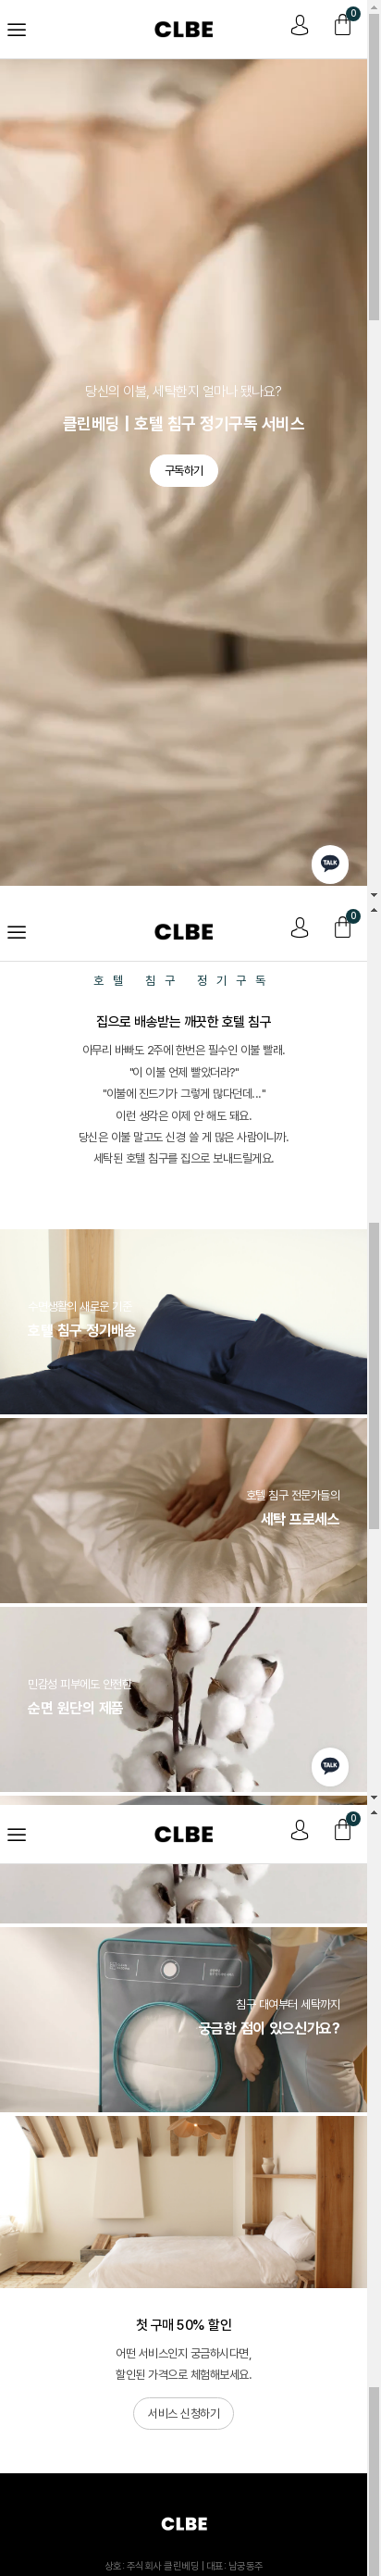

In [14]:
import io
from PIL import Image
import numpy as np
import unittest
import argparse
import datetime
import sys
import csv
import os
import time
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import TimeoutException

from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

from selenium import webdriver
from urllib.parse import urljoin
import traceback
from icecream import ic
import base64
import pandas as pd
import locale
from io import StringIO
# from needle.cases import NeedleTestCase
# from needle.engines.perceptualdiff_engine import Engine as PerceptualDiffEngine
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError
import requests
from PIL import Image


def get_web_driver():
    # profile_path = "~/.config/google-chrome/Profile 9" #집에서 작업할 때
    profile_path = "/home/max/.config/google-chrome/Default"  # 회사에서 작업할 때
    chrome_options = Options()
    chrome_options.add_argument("--user-data-dir=" + profile_path)
    # UI 띄우지 않고 실행하기위한 옵션
    chrome_options.add_argument("--headless")  # Headless 모드 활성화
    cpath = ChromeDriverManager().install()
    print('drifver path', cpath)
    return webdriver.Chrome(executable_path=cpath, options=chrome_options)


def get_full_page_screenshot(url, window_size=(412, 975)):
    # 웹 드라이버 설정 및 초기화
    # profile_path = "/home/max/.config/google-chrome/Default"  # 적절한 프로필 경로 설정
    # chrome_options = Options()
    # chrome_options.add_argument("--user-data-dir=" + profile_path)
    # chrome_options.add_argument("--headless")
    # driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)
    driver = get_web_driver()
    # 웹 페이지 열기
    driver.get(url)
    driver.set_window_size(*window_size)
    time.sleep(4)

    # 전체 페이지 높이 계산
    total_height = driver.execute_script("return document.body.parentNode.scrollHeight")

    # 스크롤하며 스크린샷 찍기
    slices = []
    offset = 0
    while offset < total_height:
        driver.execute_script("window.scrollTo(0, %s);" % offset)
        time.sleep(0.5)  # 스크롤 후 잠시 기다림
        img_binary = driver.get_screenshot_as_png()
        img = Image.open(io.BytesIO(img_binary))
        slices.append(img)
        offset += window_size[1]

    # 스크린샷 합치기
    screenshot = Image.new('RGB', (slices[0].width, total_height))
    offset = 0
    for img in slices:
        screenshot.paste(img, (0, offset))
        offset += img.height

    driver.quit()
    return screenshot


# 전체 페이지 스크린샷 얻기
full_screenshot = get_full_page_screenshot("http://cleanb.life")
# full_screenshot.show()  # 스크린샷 보기
full_screenshot

# # 검색창 엘리먼트 가져오기
# elm_body = driver.find_element_by_xpath( '/html/body')

# # 검색창 엘리먼트만 스크린샷
# screenshot = driver.get_screenshot_as_png()  # .get_screenshot()
# Image(screenshot)

In [ ]:
import json
SLACK_BOT_TOKEN = (

)
channel_id = "C0637SWFXFS"  # maxmonitor
channel_pjw_id = "D04HE04L86N"
slack_client = WebClient(token=SLACK_BOT_TOKEN)


# maxmonitor channel
slack_webhook_url = (
)


def upload_file_and_get_ts(channel_id, file_path, initial_comment=""):
    try:
        # 파일 업로드 및 초기 코멘트와 함께 메시지 게시
        upload_response = slack_client.files_upload(
            channels=channel_id, initial_comment=initial_comment, file=file_path
        )
        file_id = upload_response["file"]["id"]
        # ic(upload_response["file"])
        # 업로드된 파일과 관련된 메시지의 타임스탬프 추출
        image_url = slack_client.files_sharedPublicURL(file=file_id)["file"][
            "permalink_public"
        ]
        message_ts = upload_response["file"]["shares"]["private"][channel_id][0]["ts"]
        file_name = upload_response["file"]["name"]

        return message_ts, image_url, file_name

    except SlackApiError as e:
        print(f"Error uploading file: {e.response['error']}")
        return None, None


def delete_message(channel_id, message_ts):
    try:
        result = slack_client.chat_delete(
            channel=channel_id, ts=message_ts  # Timestamp of the message to be deleted
        )
        return result
    except SlackApiError as e:
        print(f"Error deleting message: {e.response['error']}")


def send_slack_msg_image_at_once(title, message, file_path, ok=True):
    # attachments 형태의 포맷된 메세지를 작성합니다.
    ccode = "#2c9b3d" if ok else "#d75c15"
    ok_word = "OK" if ok else "NG"
    attachment = {"mrkdwn_in": ["text"], "color": ccode, "text": message}

    if file_path:
        message_ts, image_url, fname = upload_file_and_get_ts(channel_pjw_id, file_path, file_path.split('/')[-1])
        ic(message_ts, image_url)
        message += f"\n_{fname}_" if file_path is not None else "\n"
        attachment["image_url"] = image_url
        attachment["text"] = message

    try:
        # 메세지를 보냅니다.
        result = slack_client.chat_postMessage(
            channel=channel_id,
            text=f"*[{ok_word}] {title}*",
            attachments=[attachment],
        )
        print(attachment)
        return result
    except SlackApiError as e:
        print(f"Error sending message: {e.response['error']}")
    finally:
        if file_path:
            delete_message(channel_pjw_id, message_ts)


send_slack_msg_image_at_once(
    "Test image upload",
    "*제목*:`결과1123`\n*제목2*: `456787`",
    "/home/max/cleanbeding/anycrawler/needle/imgs/base/로그인.png",
    True,
)

/home/max/miniconda3/envs/needle_env/lib/python3.7/site-packages/slack_sdk/web/internal_utils.py:417: UserWarning: client.files_upload() may cause some issues like timeouts for relatively large files. Our latest recommendation is to use client.files_upload_v2(), which is mostly compatible and much stabler, instead.
  warnings.warn(message)
ic| message_ts: '1705242141.574749'
    image_url: 'https://slack-files.com/T04G78BDB37-F06EH32DX4Y-f64a187c5e'


{'mrkdwn_in': ['text'], 'color': '#2c9b3d', 'text': '*제목*:`결과1123`\n*제목2*: `456787`\n_로그인.png_', 'image_url': 'https://slack-files.com/T04G78BDB37-F06EH32DX4Y-f64a187c5e'}


아래는 슬랙에서 권고하는 block kit 을 사용하려고 한 코드이지만 슬랙으로 업로드한 퍼블릭 이미지만 넣으면 제대로 동작하지 않는 문제가 있어 보류해둔다.


In [ ]:
import json
SLACK_BOT_TOKEN = (
)
slack_client = WebClient(token=SLACK_BOT_TOKEN)
# webhook-monitoring-alert

# maxmonitor channel


def upload_file_and_get_ts(channel_id, file_path, initial_comment=""):
    try:
        # 파일 업로드 및 초기 코멘트와 함께 메시지 게시
        upload_response = slack_client.files_upload(
            channels=channel_id, initial_comment=initial_comment, file=file_path
        )
        file_id = upload_response["file"]["id"]
        # ic(upload_response["file"])
        # 업로드된 파일과 관련된 메시지의 타임스탬프 추출
        image_url = slack_client.files_sharedPublicURL(file=file_id)["file"][
            "permalink_public"
        ]
        message_ts = upload_response["file"]["shares"]["private"][channel_id][0]["ts"]
        file_name = upload_response["file"]["name"]

        return message_ts, image_url, file_name

    except SlackApiError as e:
        print(f"Error uploading file: {e.response['error']}")
        return None, None


def delete_message(channel_id, message_ts):
    try:
        result = slack_client.chat_delete(
            channel=channel_id, ts=message_ts  # Timestamp of the message to be deleted
        )
        return result
    except SlackApiError as e:
        print(f"Error deleting message: {e.response['error']}")


def send_slack_msg_image_at_once(title, message, file_path, ok=True):
    # attachments 형태의 포맷된 메세지를 작성합니다.
    ccode = "#2c9b3d" if ok else "#d75c15"
    ok_word = "OK" if ok else "NG"

   # attchment = {"mrkdwn_in": ["text"], "color": ccode, "text": message}
    attachments =  [
            {
                "color": ccode,
                "blocks": [
                    {
                        "type": "header",
                        "text": {
                            "type": "plain_text",
                            "text": f"[{ok_word}] {title}",
                            "emoji": False,
                        },
                    },
                    {
                        "type": "section",
                        "text": {
                            "type": "mrkdwn",
                            "text": message,
                        },
                    },
                ],
            }
        ]
    if file_path:
        message_ts, image_url, fname = upload_file_and_get_ts(channel_pjw_id, file_path)
        ic(message_ts, image_url)
        image_url = "https://assets3.thrillist.com/v1/image/1682388/size/tl-horizontal_main.jpg"
        imgblock = {
            "type": "image",
            "title": {
                "type": "plain_text",
                "text": fname,
                "emoji": False,
            },
            "image_url": image_url,
            "alt_text": fname,
        }
        attachments[0]["blocks"].append(imgblock)
    message += "\n" + fname if file_path is not None else "\n"
    attachments1 = [
        {
            "color": "#2c9b3d",
            "blocks": [
                {
                    "type": "header",
                    "text": {
                        "type": "plain_text",
                        "text": "This is a header block",
                        "emoji": True
                    }
                },
                {
                    "type": "section",
                    "text": {
                        "type": "mrkdwn",
                        "text": "This is a mrkdwn section block :ghost: *this is bold*, and ~this is crossed out~, and <https://google.com|this is a link>"
                    }
                },
                {
                    "type": "image",
                    "title": {
                        "type": "plain_text",
                        "text": "I love tacos",
                        "emoji": True
                    },
                    "image_url": "https://assets3.thrillist.com/v1/image/1682388/size/tl-horizontal_main.jpg",
                    "alt_text": "delicious tacos"
                }
            ]
        }
    ]


    try:
        # 메세지를 보냅니다.
        print("attachments:", attachments)
        print("title:", f"[{ok_word}] {title}")
        # result = slack_client.chat_postMessage(
        #     channel=channel_id,
        #     text=f"*[{ok_word}] {title}*",
        #     attachments=[attchment],
        # )
        print(json.dumps(attachments))
        print(json.dumps(attachments1))
        result = slack_client.chat_postMessage(
            channel=channel_id,
            attachments=json.dumps(attachments),
        )
        return result

    except SlackApiError as e:
        print(f"Error sending message: {e.response['error']}")
    finally:
        if file_path:
            delete_message(channel_pjw_id, message_ts)


send_slack_msg_image_at_once(
    "Test image upload",
    "*제목*:`결과1123`\n*제목2*: `456787`\n\n",
    "/home/max/cleanbeding/anycrawler/needle/imgs/base/로그인.png",
    True,
)

/home/max/miniconda3/envs/needle_env/lib/python3.7/site-packages/slack_sdk/web/internal_utils.py:417: UserWarning: client.files_upload() may cause some issues like timeouts for relatively large files. Our latest recommendation is to use client.files_upload_v2(), which is mostly compatible and much stabler, instead.
  warnings.warn(message)


ic| message_ts: '1705240676.021549'
    image_url: 'https://slack-files.com/T04G78BDB37-F06DU8Q18BC-c4fd7e8f6f'
/home/max/miniconda3/envs/needle_env/lib/python3.7/site-packages/slack_sdk/web/internal_utils.py:291: UserWarning: The top-level `text` argument is missing in the request payload for a chat.postMessage call - It's a best practice to always provide a `text` argument when posting a message. The `text` argument is used in places where content cannot be rendered such as: system push notifications, assistive technology such as screen readers, etc.
  warnings.warn(missing_text_message, UserWarning)


attachments: [{'color': '#2c9b3d', 'blocks': [{'type': 'header', 'text': {'type': 'plain_text', 'text': '[OK] Test image upload', 'emoji': False}}, {'type': 'section', 'text': {'type': 'mrkdwn', 'text': '*제목*:`결과1123`\n*제목2*: `456787`\n\n'}}, {'type': 'image', 'title': {'type': 'plain_text', 'text': '로그인.png', 'emoji': False}, 'image_url': 'https://assets3.thrillist.com/v1/image/1682388/size/tl-horizontal_main.jpg', 'alt_text': '로그인.png'}]}]
title: [OK] Test image upload
[{"color": "#2c9b3d", "blocks": [{"type": "header", "text": {"type": "plain_text", "text": "[OK] Test image upload", "emoji": false}}, {"type": "section", "text": {"type": "mrkdwn", "text": "*\uc81c\ubaa9*:`\uacb0\uacfc1123`\n*\uc81c\ubaa92*: `456787`\n\n"}}, {"type": "image", "title": {"type": "plain_text", "text": "\ub85c\uadf8\uc778.png", "emoji": false}, "image_url": "https://assets3.thrillist.com/v1/image/1682388/size/tl-horizontal_main.jpg", "alt_text": "\ub85c\uadf8\uc778.png"}]}]
[{"color": "#2c9b3d", "blocks":